In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

### Global Imports

In [1]:
import os
import datetime
import errno
import argparse

import numpy as np
import tensorflow as tf

from tensorflow.python.keras import backend as K
from tensorflow.python.keras.optimizers import SGD, Adam
from tensorflow.python.keras.models import Sequential, Model

from deepcell import get_data
from deepcell import make_training_data
from deepcell import rate_scheduler
from deepcell.model_zoo import siamese_model
from deepcell.training import train_model_siamese_daughter

Using TensorFlow backend.


### Training the Model

In [ ]:
from deepcell import rate_scheduler
from deepcell.model_zoo import siamese_model
from deepcell.training import train_model_siamese_daughter

direc_data = '/data/npz_data/cells/HeLa/S3/movie/'
dataset = 'nuclear_movie_hela0-7_same'

#direc_data = '/data/npz_data/cells/3T3/NIH/'
#dataset = 'nuclear_movie_3t3_set1_same'

training_data = np.load('{}{}.npz'.format(direc_data, dataset))

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.01, decay=0.99)
in_shape = (32, 32, 1)
features = {"appearance", "distance", "neighborhood", "perimeter"}

model = siamese_model(input_shape=in_shape, features=features)

tracking_model = train_model_siamese_daughter(model=model,
                                              dataset=dataset,
                                              optimizer=optimizer,
                                              expt='transform_sync',
                                              it=0,
                                              batch_size=128,
                                              min_track_length=6,
                                              features=features,
                                              n_epoch=5,
                                              direc_save='/data/models/cells/HeLa/S3',
                                              direc_data=direc_data,
                                              lr_sched=lr_sched,
                                              rotation_range=180,
                                              flip=True,
                                              shear=0,
                                              class_weight=None)

### Data Review

In [ ]:
data = np.load('/data/npz_data/cells/HeLa/S3/movie/nuclear_movie_hela0-7_same.npz')
#data = np.load('/data/npz_data/cells/HeLa/S3/movie/nuclear_movie_HeLa_0_same.npz')
data.keys()
data_readable_X, data_readable_y = data['X'][()], data['y'][()]
print('X Shape:', data_readable_X.shape)
print('y Shape:', data_readable_y.shape)

In [ ]:
import matplotlib.pyplot as plt
from skimage.io import imshow

img_raw = data_readable_X[0,0,:,:,0]
img_ann = data_readable_y[0,0,:,:,0]

# Visualize the result 
fig, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0].imshow(img_raw, interpolation='none', cmap='gray')
ax[1].imshow(img_ann, interpolation='none', cmap='gray')
ax[0].set_title('Contrast (or Raw) Images')
ax[1].set_title('Annotated Images')
plt.show()

In [ ]:
train_dict, val_dict = get_data('/data/npz_data/cells/HeLa/S3/movie/nuclear_movie_hela0-7_same.npz',
                                        mode='siamese_daughters')

In [ ]:
import matplotlib.pyplot as plt
from skimage.io import imshow

# Compare 2 images
img_1 = train_dict['X'][0,1,:,:,0]
img_2 = train_dict['y'][0,1,:,:,0]

fig, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0].imshow(img_1, interpolation='none', cmap='gray')
ax[1].imshow(img_2, interpolation='none', cmap='gray')
plt.show()

### Verifying Model Accuracy with Confusion Matrix

In [27]:
# Import the tracking function
from deepcell.tracking import cell_tracker

# Load up data to test
train_dict, val_dict = get_data('/data/npz_data/cells/HeLa/S3/movie/nuclear_movie_hela0-7_same.npz',
                                        mode='siamese_daughters')

In [ ]:
import deepcell.image_generators as generators

datagen_val = generators.SiameseDataGenerator(
        rotation_range=0,  # randomly rotate images by 0 to rotation_range degrees
        shear_range=0,  # randomly shear images in the range (radians , -shear_range to shear_range)
        horizontal_flip=0,  # randomly flip images
        vertical_flip=0)  # randomly flip images

val_iterator = generators.SiameseIterator(train_dict,
                                          datagen_val,
                                          occupancy_grid_size=10,
                                          crop_dim=32,
                                          min_track_length=5,
                                          features={"appearance", "distance", "neighborhood", "perimeter"})

In [ ]:
from sklearn.metrics import confusion_matrix

Y = []
Y_pred = []
for i in range(1,1001):
    if i % 100 == 0:
        print(".", end="")
    lst, y_true = next(val_iterator)
    y_true = list(map(np.argmax, y_true))
    y_pred = list(map(np.argmax, tracking_model.predict(lst)))
    Y.extend(y_true)
    Y_pred.extend(y_pred)

confusion_matrix(Y, Y_pred)

In [ ]:
sum(np.array(Y) == np.array(Y_pred)) / len(Y)

### Tracking Test

In [2]:
# Load up data to test
train_dict, val_dict = get_data('/data/npz_data/cells/HeLa/S3/movie/nuclear_movie_hela0-7_same.npz',
                                        mode='siamese_daughters')

In [3]:
from deepcell.model_zoo import siamese_model
from deepcell.tracking import cell_tracker

# Import the tracking model
MODEL_DIR = '/data/models'
PREFIX = 'cells/HeLa/S3'
in_shape = (32, 32, 1)
features = {"appearance", "neighborhood", "distance", "regionprop"}

# Now we need to re-instantiate the model and load weights
siamese_weights_file = '2018-11-04_nuclear_movie_hela0-7_same_[a,d,n,r]_og=20_epochs=5_normalized_0.h5'
siamese_weights_file = os.path.join(MODEL_DIR, PREFIX, siamese_weights_file)

tracking_model = siamese_model(input_shape=in_shape, occupancy_grid_size=20, features=features)
tracking_model.load_weights(siamese_weights_file)

In [4]:
#test_data = np.load("/data/data/cells/HeLa/S3/set0/HeLaTrackingTests/nuclear_movie_HeLa_set0_large.npz")


In [5]:
test_data['X'][0].shape

(45, 1080, 1280, 1)

In [31]:
import importlib
import deepcell.tracking
importlib.reload(deepcell.tracking)

batch = 1
trial = deepcell.tracking.cell_tracker(train_dict['X'][batch], train_dict['y'][batch],
#trial = deepcell.tracking.cell_tracker(test_data['X'][0], test_data['y'][0],
                     tracking_model,
                     max_distance=200,
                     track_length=5, division=0.5, birth=0.9, death=0.9,
                     occupancy_grid_size=20,
                     features=features)
trial._track_cells()

max label 4.0
max label 8.0
max label 12.0
max label 16.0
max label 20.0
max label 24.0
max label 30.0
max label 35.0
max label 40.0
max label 45.0
max label 51.0
max label 57.0
max label 63.0
max label 69.0
max label 75.0
max label 81.0
max label 87.0
max label 92.0
max label 97.0
max label 102.0
max label 108.0
max label 114.0
max label 120.0
max label 126.0
max label 132.0
max label 138.0
max label 144.0
max label 149.0
max label 154.0
max label 159.0
max label 165.0
max label 171.0
max label 177.0
max label 183.0
max label 189.0
max label 195.0
max label 201.0
max label 207.0
max label 213.0
max label 219.0
Tracking frame 1


/usr/local/lib/python3.5/dist-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/usr/local/lib/python3.5/dist-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant

cells in frame [5 6 7 8]
Tracking frame 2
cells in frame [ 9 10 11 12]
Tracking frame 3
cells in frame [13 14 15 16]
Tracking frame 4
cells in frame [17 18 19 20]
Tracking frame 5
cells in frame [21 22 23 24]
Tracking frame 6
cells in frame [25 26 27 28 29 30]
New track
New track
Tracking frame 7
cells in frame [31 32 33 34 35]
Tracking frame 8
cells in frame [36 37 38 39 40]
Tracking frame 9
cells in frame [41 42 43 44 45]
Tracking frame 10
cells in frame [46 47 48 49 50 51]
Tracking frame 11
cells in frame [52 53 54 55 56 57]
Tracking frame 12
cells in frame [58 59 60 61 62 63]
Tracking frame 13
cells in frame [64 65 66 67 68 69]
Tracking frame 14
cells in frame [70 71 72 73 74 75]
Tracking frame 15
cells in frame [76 77 78 79 80 81]
Tracking frame 16
cells in frame [82 83 84 85 86 87]
Tracking frame 17
cells in frame [88 89 90 91 92]
Tracking frame 18
cells in frame [93 94 95 96 97]
Tracking frame 19
cells in frame [ 98  99 100 101 102]
Tracking frame 20
cells in frame [103 104 105 

## Visualizing the Result

In [23]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def get_js_video(images, batch=0, channel=0):
    fig = plt.figure()    
    ims = []
    for i in range(images.shape[1]):
        im = plt.imshow(images[batch, i, :, :, channel], animated=True, cmap='cubehelix', vmin=0, vmax=15)
        ims.append([im])
        ani = animation.ArtistAnimation(fig, ims, interval=75, repeat_delay=1000)
    return HTML(ani.to_jshtml())

In [11]:
print("track ids:", len(trial.tracks))
trial.tracks[0]['frames']
# The labels are all advanced on

# for key, track in trial.tracks.items():
#     print(key, track['daughters'])

track ids: 9


[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [ ]:
for i in range(40):
    print(i, np.unique(trial.y_tracked[i]))

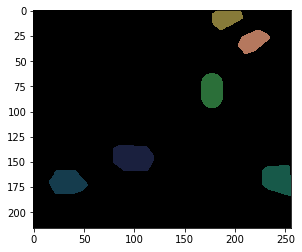

In [32]:
get_js_video(np.expand_dims(trial.y_tracked, axis=0))

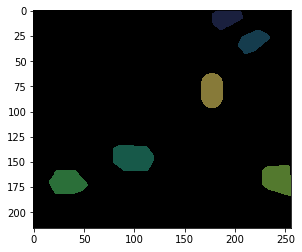

In [33]:
#get_js_video(test_data['y'])
#get_js_video(train_dict['y'], batch=batch)
get_js_video(train_dict['y'], batch=1)

## Save the Raw and Tracked Output

In [ ]:
channel = 0

for i in range(45):
    #name_raw = os.path.join('tracking_movies/test_true2_{:02}_.png'.format(i))
    name_tracked = os.path.join('tracking_movies/test_tracked3_{:02}_.png'.format(i))
    #plt.imsave(name_raw, test_data['y'][0, i, :, :, channel], cmap='jet')
    plt.imsave(name_tracked, trial.y_tracked[i, :, :, channel], cmap='cubehelix', vmin=0, vmax=250)


In [34]:
print(trial.y_tracked.shape)

(40, 216, 256, 1)


In [41]:
print([key for key in trial.tracks.keys()])
print([trial.tracks[key]['label'] for key in trial.tracks.keys()])
print([trial.tracks[key]['parent'] for key in trial.tracks.keys()])
print([trial.tracks[key]['daughters'] for key in trial.tracks.keys()])
print([trial.tracks[key]['capped'] for key in trial.tracks.keys()])
print(trial.tracks[0]['frames'])
print(trial.tracks[5]['frames'])
print(trial.tracks[6]['frames'])
print(trial.tracks[7]['frames'])

[0, 1, 2, 3, 4, 5, 6, 7]
[1, 2, 3, 4, 5, 6, 7, 8]
[None, None, None, None, None, None, 0, 0]
[[6, 7], [], [], [], [], [], [], []]
[True, False, False, False, False, False, False, False]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
[6, 10, 11, 12, 13, 14, 15, 16, 20, 21, 22, 23, 24, 25, 26, 30, 31, 32, 33, 34, 35]
[36, 37, 38, 39]
[36, 37, 38, 39]


In [ ]:
BASE_DIR = '/data/cells/'
cell_type = 'HeLa/S3'
cell_set = 0
montage

filename = '2018-11-04_nuclear_movie_hela0-7_same_[a,d,n,r]_og=20_epochs=5_normalized_0.h5'
other_filename = os.path.join(MODEL_DIR, PREFIX, siamese_weights_file)

In [ ]:
from sklearn.metrics import confusion_matrix
from IPython.display import clear_output
import time

datagen_val = SiameseDataGenerator(
    rotation_range=180,  # randomly rotate images by 0 to rotation_range degrees
    shear_range=0,  # randomly shear images in the range (radians , -shear_range to shear_range)
    horizontal_flip=0,  # randomly flip images
    vertical_flip=0)  # randomly flip images

batch_size=128
min_track_length=5
# fit the model on the batches generated by datagen.flow()
test = datagen_val.flow(train_dict, batch_size=batch_size, min_track_length=min_track_length, shuffle=False)

cm = np.zeros((3,3))
N_div = 0.
N_tot = 0.

for batch_x, batch_y in test:
    clear_output(wait=True)
    
    y_pred = tracking_model.predict(batch_x)
    
    truth = np.argmax(batch_y, axis=-1)
    pred = np.argmax(y_pred, axis=-1)
    cm_temp = confusion_matrix(truth,pred)
    if cm_temp.shape[0] == 2:
        cm[0:2,0:2] += cm_temp
    else:
        cm += confusion_matrix(truth,pred)
        
    N_div += np.sum(truth == 2)
    N_tot += truth.shape[0]
    
    print(np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2), N_div/N_tot)

    
# y_true = test.classes
# y_pred = tracking_model.predict_generator(test)
# print(y_pred)
# Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
# y_pred = model.predict_classes(x_test)
# print(classification_report(y_true, np.argmax(y_pred, axis=-1)))